
## Download the data

In [1]:
from pathlib import Path
import tarfile
import urllib.request
import pandas as pd

In [21]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

C:\Users\nesre\AppData\Local\Temp\ipykernel_10420\3618432857.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


## A Quick Look at the Data

In [22]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [23]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* All features are numerical, except ocean_proximity.
* Our dataset has 20,640 districts, i.e., rows (data samples).
* It contains 10 columns.
* total_rooms has missing values.

In [24]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [25]:
housing_full[housing["total_bedrooms"].isna()].shape[0]

207

* 207 missing values

In [26]:
housing_full['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [29]:
housing_full["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

* the colomn ocean_proximity has 5 unique values.

#### Data Visualization at glance

In [9]:
import matplotlib.pyplot as plt

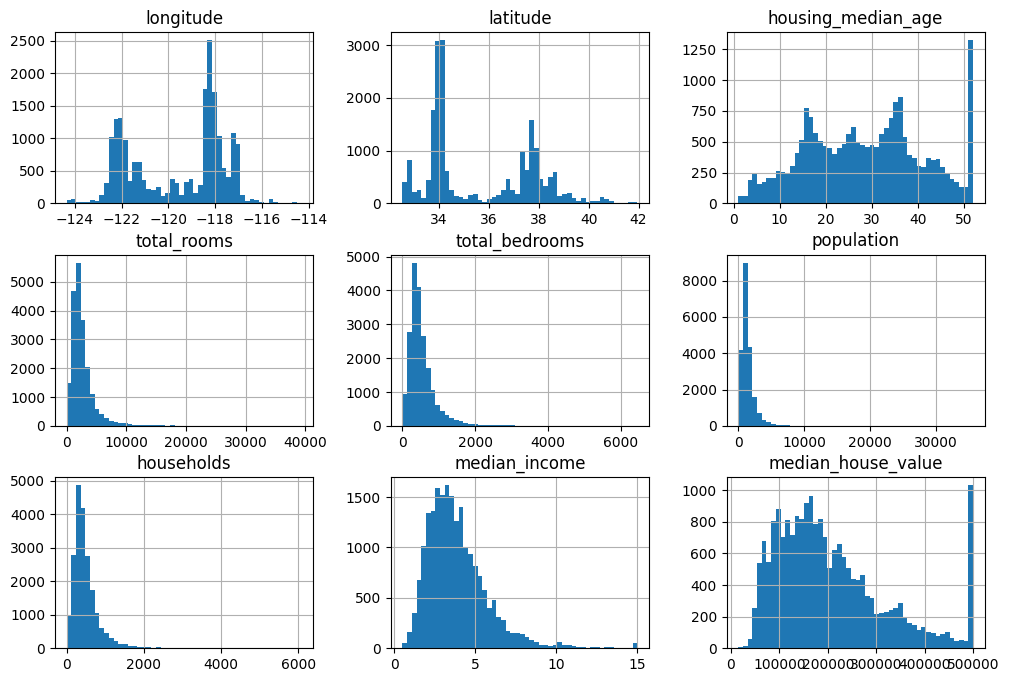

In [32]:
housing_full.hist(bins=50, figsize=(12,8))

plt.show()

* Some distributions are Right skewed As a result some models may struggle to find patterns for such data distribution.

#### Create a Test Set

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

* based on the convo with the client you found that income distribution really matters. So, it is better to use distribution based sampling instead of random sampling.

* If you split train/test randomly, some income groups may disappear or be under-represented.

In [ ]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [34]:
housing_full["income_cat"] = pd.cut(housing_full["median_income"],
                                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

In [40]:
housing_full["income_cat"].head()

0    5
1    5
2    5
3    4
4    3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [45]:
cat_counts = housing_full["income_cat"].value_counts().sort_index()
cat_counts

income_cat
1     822
2    6581
3    7236
4    3639
5    2362
Name: count, dtype: int64

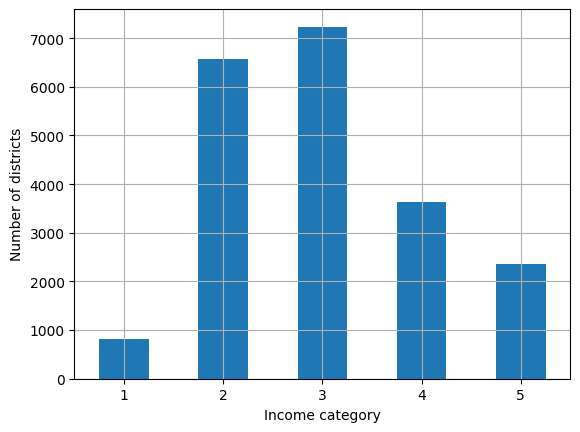

In [46]:
cat_counts.plot(kind="bar" ,rot=0, grid=True)

plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [53]:
# Stratified Sampling.

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42,  stratify=housing["income_cat"])

In [56]:
strat_train_set.shape

(16512, 11)

In [57]:
strat_test_set.shape

(4128, 11)

## Data Visualization to Gain Insights

In [58]:
housing = strat_train_set.copy()

### Visualize Geographical Data

In [59]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3


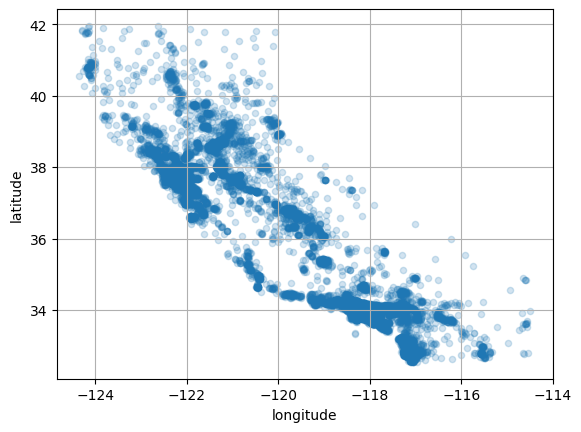

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, grid=True)

plt.show()

* It looks like California - the dataset is for houses in california, that is why!
* high population around the beach, and this makes sense.

<Axes: xlabel='longitude', ylabel='latitude'>

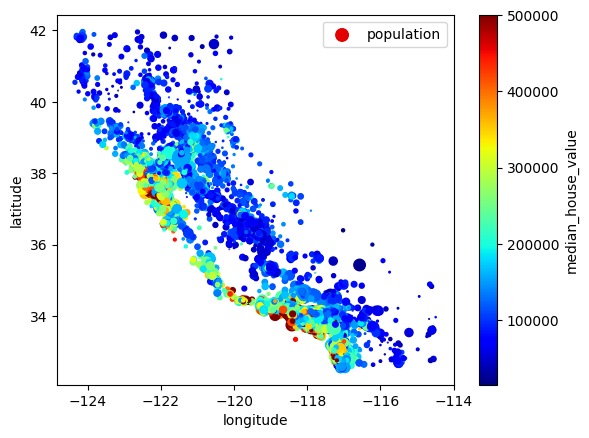

In [72]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap="jet")